# 股利政策交易

In [ ]:
import pandas as pd
import pymongo

In [ ]:
path = r'C:\Users\ChastLai\Documents\Data\股利政策.xlsx'
div_cash_q = pd.read_excel(path, sheet_name='季現金股利', header=4)
div_cash_y = pd.read_excel(path, sheet_name='年現金股利', header=4)
div_share_q = pd.read_excel(path, sheet_name='季股票股利', header=4)
div_share_y = pd.read_excel(path, sheet_name='年股票股利', header=4)
date_cash_q = pd.read_excel(path, sheet_name='季除息', header=4)
date_cash_y = pd.read_excel(path, sheet_name='年除息', header=4)
date_share_q = pd.read_excel(path, sheet_name='季除權', header=4)
date_share_y = pd.read_excel(path, sheet_name='年除權', header=4)

In [ ]:
client = pymongo.MongoClient()
db = client['Data']
price = pd.concat([pd.DataFrame(db[x].find({}, {'_id': 0, '日期': 1, '收盤價': 1})).set_index('日期') for x in db.list_collection_names()], axis=1)
price.columns = db.list_collection_names()
price = price.loc[price.index.dropna()]

In [ ]:

報酬 = dict()
for k in price.columns:
    
    da_s = date_share_y[date_share_y['股票代號'] == int(k)].T.iloc[2:].reset_index(drop=True)
    di_s = div_share_y[div_share_y['股票代號'] == int(k)].T.iloc[2:].reset_index(drop=True)
    股票股利 = pd.concat([da_s, di_s], axis=1)
    股票股利.columns = ['日期', '股票股利']
    da_c = date_cash_y[date_cash_y['股票代號'] == int(k)].T.iloc[2:].reset_index(drop=True)
    di_c = div_cash_y[div_cash_y['股票代號'] == int(k)].T.iloc[2:].reset_index(drop=True)
    現金股利 = pd.concat([da_c, di_c], axis=1)
    現金股利.columns = ['日期', '現金股利']

    現金股利.dropna(inplace=True)
    現金股利 = 現金股利.groupby('日期').sum()

    股票股利.dropna(inplace=True)
    股票股利 = 股票股利.groupby('日期').sum()

    股利 = pd.concat([現金股利, 股票股利], axis=1).sort_index()
    p = price.loc[:, k].dropna()
    idx = list(set(p.index) & set(股利.index))
    分母 = price.loc[idx, k].shift(1)
    # 設定要用什麼當收入
    買進收入 = (p.shift(-20) - p.shift(20)).loc[idx].sort_index()
    買進收入 = (買進收入 + 股利.loc[idx].sum(axis=1).sort_index()) / 分母
    報酬[k] = 買進收入

In [ ]:
import matplotlib.pyplot as plt
pd.options.plotting.backend = "matplotlib"
plt.rcParams['font.family'] = ['Microsoft JhengHei'] # 中文標籤
plt.rcParams['axes.unicode_minus'] = False # 負號
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.options.display.float_format = '{:,.4f}'.format
fig = plt.figure(figsize=(16, 9))
color = 0.01
f = 1
for t in stk_list:
    color += 0.05
    fig.add_subplot(3, 4, f)
    plt.plot(報酬[str(t)].cumsum())
    f += 1
plt.show()

# 價值股選股

* 本益比 <15
* PB < 2
* 殖利率 > 4
* 成交量 > 50%股
* C > 60MA > 120MA
* EPS 季成長
* 營收 > 前年營收

In [338]:
import pymongo
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.options.plotting.backend = "matplotlib"
plt.rcParams['font.family'] = ['Microsoft JhengHei'] # 中文標籤
plt.rcParams['axes.unicode_minus'] = False # 負號
pd.set_option('display.max_rows', 50)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.options.display.float_format = '{:,.4f}'.format

client = pymongo.MongoClient()
db = client['Data']
db1 = client['Index']
print(pd.DataFrame(db['2330'].find({})).columns)

Index(['_id', '整體維持率(%)', '融券維持率(%)', '融資維持率(%)', '融券成本(推估)', '融資成本(推估)', '資買',
       '資賣', '資現償', '資餘', '資增減', '資限', '券買', '券賣', '券賣金額(千)', '券現償', '券增減',
       '券餘', '資券相抵', '券資比', '資使用率', '券使用率', '外資買賣超', '外資及陸資(不含外資自營商)買賣超',
       '外資自營商買賣超', '外資買賣超金額(千)', '外資持股比率(%)', '外資持股成本', '外資尚可投資比率(%)',
       '自營商買賣超', '自營商買賣超(自行買賣)', '自營商買賣超(避險)', '自營商買賣超金額(千)', '自營商持股比率(%)',
       '自營商持股成本', '投信買賣超', '投信買賣超金額(千)', '投信持股比率(%)', '投信持股成本', '主力買賣超(張數)',
       '主力券商淨買超家數', '主力券商淨賣超家數', '買超券商家數', '賣超券商家數', '還原開盤價', '還原最高價', '還原最低價',
       '還原收盤價', '漲跌', '漲幅(%)', '振幅(%)', '成交量', '成交筆數', '成交金額(千)', '均張',
       '成交量變動(%)', '均張變動(%)', '股本(百萬)', '總市值(億)', '市值比重(%)', '本益比', '股價淨值比',
       '本益比(近四季)', '週轉率(%)', '成交值比重(%)', '漲跌停', '開盤價', '最高價', '最低價', '收盤價',
       '股票代號', '股票名稱', '日期'],
      dtype='object')


In [339]:
PE = pd.concat([pd.DataFrame(db[x].find({}, {'_id': 0, '日期': 1, '本益比': 1})).set_index('日期') for x in db.list_collection_names()], axis=1).dropna(how='all'); PE.columns = db.list_collection_names()
PB = pd.concat([pd.DataFrame(db[x].find({}, {'_id': 0, '日期': 1, '股價淨值比': 1})).set_index('日期') for x in db.list_collection_names()], axis=1).dropna(how='all'); PB.columns = db.list_collection_names()
收盤價 = pd.concat([pd.DataFrame(db[x].find({}, {'_id': 0, '日期': 1, '還原收盤價': 1})).set_index('日期') for x in db.list_collection_names()], axis=1).dropna(how='all'); 收盤價.columns = db.list_collection_names()
成交金額 = pd.concat([pd.DataFrame(db[x].find({}, {'_id': 0, '日期': 1, '成交金額(千)': 1})).set_index('日期') for x in db.list_collection_names()], axis=1).dropna(how='all'); 成交金額.columns = db.list_collection_names() 
MA60 = 收盤價.rolling(60).mean()
MA120 = 收盤價.rolling(120).mean()
大盤收盤價 = pd.DataFrame(db1['TWA00'].find({}, {'_id': 0, '日期': 1, '還原收盤價': 1})).set_index('日期').dropna(how='all')

In [340]:
def change_Q(se: pd.Series):
    new = list()
    for s in se:
        if 'Q1' in s:
            s = s[:4] + '0515'
        elif 'Q2' in s:
            s = s[:4] + '0814'
        elif 'Q3' in s:
            s = s[:4] + '1114'
        elif 'Q4' in s:
            s = str(int(s[:4]) + 1) + '0331'
        new.append(s)
    return new

EPS = pd.read_excel(r'C:\Users\ChastLai\Documents\Data\價值股資料.xlsx', sheet_name='EPS', header=4)
EPS = EPS.drop('股票名稱', axis=1).set_index('股票代號')
EPS.columns = [s.split('每')[0] for s in EPS.columns]
EPS.columns = change_Q(EPS.columns)
EPS.columns = pd.to_datetime(EPS.columns)
EPS = EPS.T
預估EPS = pd.read_excel(r'C:\Users\ChastLai\Documents\Data\價值股資料.xlsx', sheet_name='預估EPS', header=4)
預估EPS = 預估EPS.drop('股票名稱', axis=1).set_index('股票代號')
預估EPS.columns = [s.split('稅')[0] for s in 預估EPS.columns]
預估EPS.columns = change_Q(預估EPS.columns)
預估EPS.columns = pd.to_datetime(預估EPS.columns)
預估EPS = 預估EPS.T
# 這個為年單位
營業收入淨額 = pd.read_excel(r'C:\Users\ChastLai\Documents\Data\價值股資料.xlsx', sheet_name='營業收入淨額', header=4)
營業收入淨額 = 營業收入淨額.drop('股票名稱', axis=1).set_index('股票代號')
營業收入淨額.columns = [str(int(s.split('營')[0]) + 1) + '0331' for s in 營業收入淨額.columns]
營業收入淨額.columns = pd.to_datetime(營業收入淨額.columns)
營業收入淨額 = 營業收入淨額.T
殖利率 = pd.read_excel(r'C:\Users\ChastLai\Documents\Data\價值股資料.xlsx', sheet_name='殖利率', header=4)
殖利率 = 殖利率.drop('股票名稱', axis=1).set_index('股票代號')
殖利率.columns = [s.split('殖')[0] for s in 殖利率.columns]
殖利率.columns = pd.to_datetime(殖利率.columns)
殖利率 = 殖利率.T


In [341]:
殖利率 = 殖利率.loc[PE.index.intersection(殖利率.index)]
EPS = EPS.pct_change().loc[PE.index[0]:]
預估EPS = 預估EPS.pct_change().loc[PE.index[0]:]
營業收入淨額 = 營業收入淨額.pct_change().loc[PE.index[0]:]

In [342]:
def creat_to_daily(df: pd.DataFrame):
    n = pd.DataFrame(columns=PE.columns, index=PE.index.union(df.index))
    for i in df.index:
        for c in df.columns:
            n.at[i, str(c)] = df.at[i, c]
    return n.fillna(method='ffill')
EPS_n = creat_to_daily(EPS).loc[PE.index]
預估EPS_n = creat_to_daily(預估EPS).loc[PE.index]
營業收入淨額_n = creat_to_daily(營業收入淨額).loc[PE.index]
殖利率.columns = 殖利率.columns.astype(str)

In [362]:
buy = (PE < 15)&\
    (PB < 1.5)&\
    (成交金額.ge(成交金額.median(axis=1), axis=0))&\
    (收盤價 > MA60)&\
    (收盤價 > MA120)&\
    (EPS_n > 0)&\
    (營業收入淨額_n > 0)&\
    (殖利率 > 0)

In [363]:
# 檢視策略正確性
日期 = '2022-09-01'
股票 = '1444'
print('PE<15: ', PE.at[日期, 股票])
print('PB<1.5: ', PB.at[日期, 股票])
print('成交金額>median: ', 成交金額.at[日期, 股票], ' > ', 成交金額.loc[日期].median())
print('收盤價>60MA, 120MA: ', 收盤價.at[日期, 股票], ' > 60MA: {:.2f}'.format(MA60.at[日期, 股票]), ' 120MA: {:.2f}'.format(MA120.at[日期, 股票]))
print('EPS_n>0: {:.2f}'.format(EPS_n.at[日期, 股票]))
print('營業收入淨額_n>0: {:.2f}'.format(營業收入淨額_n.at[日期, 股票]))
print('殖利率>4 {:.2f}'.format(殖利率.at[日期, 股票]))

PE<15:  11.3
PB<1.5:  1.0
成交金額>median:  24162.0  >  10148.0
收盤價>60MA, 120MA:  11.35  > 60MA: 10.35  120MA: 10.38
EPS_n>0: 0.18
營業收入淨額_n>0: 0.30
殖利率>4 2.64


In [365]:
一個月損益 = (收盤價.shift(-22) - 收盤價.shift(-1)) / 收盤價.shift(-1)
月初 = buy.groupby(pd.Grouper(freq='m')).head(1)
月末 = buy.groupby(pd.Grouper(freq='m')).tail(1)
季初 = buy.groupby(pd.Grouper(freq='q')).head(1)
季末 = buy.groupby(pd.Grouper(freq='q')).tail(1)
年初 = buy.groupby(pd.Grouper(freq='1y')).head(1)

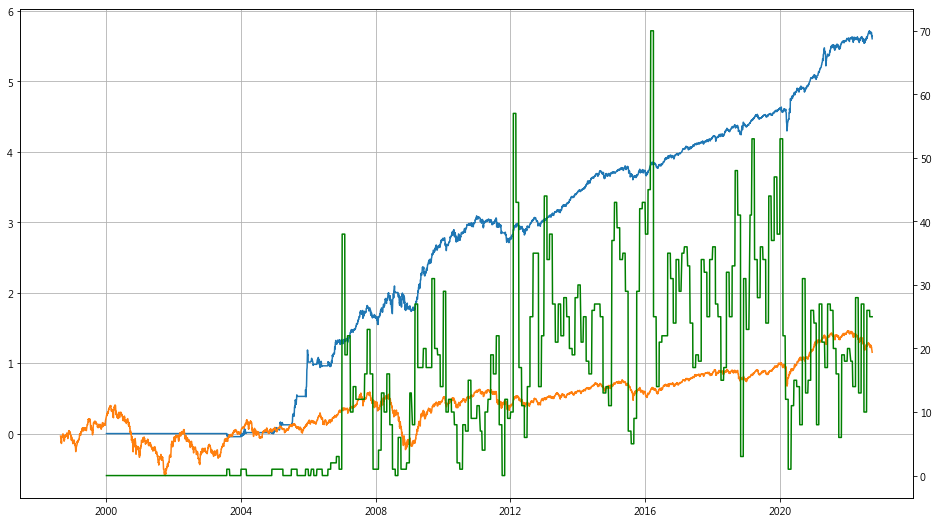

當前持倉:  Index(['1444', '5371', '4532', '4960', '2548', '1434', '2317', '1587', '2359',
       '1605', '6114', '2451', '2211', '5225', '6227', '1527', '1336', '2812',
       '3531', '3265', '6188', '1102', '8936', '8091', '4958'],
      dtype='object')


In [366]:
def 轉日資料處理(df: pd.DataFrame):
    轉日 = pd.DataFrame(index=收盤價.index, columns=收盤價.columns)
    for i in df.index:
        for c in df.columns:
            轉日.at[i, c] = df.at[i, c]
    轉日.fillna(method='ffill', inplace=True)
    return 轉日


def 損益(轉日: pd.DataFrame):
    大盤損益 = 大盤收盤價.pct_change().cumsum()
    日損益 = (收盤價.pct_change().shift(-1))
    換股日損益 = 轉日 * 日損益
    換股日平均損益 = 換股日損益.sum(axis=1) / 轉日.sum(axis=1)
    fig, ax = plt.subplots(figsize=(16, 9))
    ax1 = ax.twinx()
    ax.plot(換股日平均損益.fillna(0).cumsum())
    ax.plot(大盤損益)
    ax1.plot(轉日.sum(axis=1), color='green')
    ax.grid(True)
    plt.show()
    print('當前持倉: ', 轉日.iloc[-1][轉日.iloc[-1]].index)

def 損益金額(轉日: pd.DataFrame):
    持倉金額 = (轉日 * 收盤價 * 1000).sum(axis=1)
    大盤損益 = (大盤收盤價.pct_change().mul(持倉金額, axis=0)).cumsum()
    日損益 = (收盤價.pct_change().shift(-1))
    換股日損益 = 轉日 * 日損益 * 1000
    換股日平均損益 = 換股日損益.sum(axis=1)
    fig, ax = plt.subplots(figsize=(16, 9))
    ax1 = ax.twinx()
    ax.plot(換股日平均損益.fillna(0).cumsum())
    #ax.plot(大盤損益)
    ax1.plot(轉日.sum(axis=1), color='green')
    ax.grid(True)
    plt.show()
    print('當前持倉: ', 轉日.iloc[-1][轉日.iloc[-1] >= 1].index)


轉日 = 轉日資料處理(月初)
損益(轉日)



In [327]:
轉日 = 轉日資料處理(年初)

In [337]:
# 個別策略
bs = 轉日.copy()
bs_ = 轉日.copy()
# 新增一個全為0的表
bs.iloc[:, :] = 0
bs_.iloc[:, :] = 0
idx1 = bs.index[0]
for idx, row in 收盤價.iterrows():
    # 將會持倉的股票
    bs_.loc[idx] = bs.loc[idx1]
    bs.loc[idx] = bs.loc[idx1]
    可持倉 = 收盤價.loc[idx][轉日.loc[idx]]
    # 錨定價格
    if 可持倉.sum() > 0:
        if (轉日.loc[idx1, 可持倉.index].sum() != 轉日.loc[idx, 可持倉.index].sum()):
            可持倉第一日 = 可持倉
        # 後面的(bs.loc[idx1, 可持倉.index] == 0)是加倉關鍵 改成 <= 3000意思是持倉市值小於三百萬
        buy_in = (收盤價.loc[idx, 可持倉.index] < 可持倉第一日*0.95)&(bs.loc[idx1, 可持倉.index] * 收盤價.loc[idx, 可持倉.index] <= 3000)
        
        if buy_in.sum() > 0 & ((收盤價.loc[idx] * bs_.loc[idx]).sum() < 100000):
            buy_in = buy_in[buy_in]
            bs.loc[idx, buy_in.index] += np.floor(1000 / 收盤價.loc[idx, buy_in.index])
            # 進場後更新可進場價格
            print(idx, 可持倉第一日.sum())
            可持倉第一日.loc[buy_in.index] = 收盤價.loc[idx, buy_in.index]
            print(idx, 可持倉第一日.sum())
    sell_out = (bs_.loc[idx] >= 1) & (轉日.loc[idx] == 0)
    if sell_out.sum() > 0:
        sell_out = sell_out[sell_out]
        bs.loc[idx, sell_out.index] = 0

        # bs.loc[idx, 可持倉.index]\
        #     [(收盤價.loc[idx, 可持倉.index] < 可持倉第一日*0.95)&\
        #     (bs.loc[idx1, 可持倉.index] == 0)] =\
        #     1000 / 收盤價.loc[idx, 可持倉.index] # 一百萬買部位，只買一次
    
    idx1 = idx

2007-01-03 00:00:00 167.78000000000003
2007-01-03 00:00:00 167.26000000000002
2007-01-04 00:00:00 167.26000000000002
2007-01-04 00:00:00 166.38000000000002
2007-01-05 00:00:00 166.38000000000002
2007-01-05 00:00:00 164.63000000000005
2007-01-08 00:00:00 164.63000000000005
2007-01-08 00:00:00 164.09000000000003
2007-01-10 00:00:00 164.09000000000003
2007-01-10 00:00:00 163.03
2007-01-11 00:00:00 163.03
2007-01-11 00:00:00 160.6
2007-01-29 00:00:00 160.6
2007-01-29 00:00:00 159.62
2007-02-01 00:00:00 159.62
2007-02-01 00:00:00 158.6
2007-03-01 00:00:00 158.6
2007-03-01 00:00:00 158.41
2007-03-03 00:00:00 158.41
2007-03-03 00:00:00 158.20999999999998
2007-03-05 00:00:00 158.20999999999998
2007-03-05 00:00:00 156.27999999999997
2007-03-14 00:00:00 156.27999999999997
2007-03-14 00:00:00 155.82
2007-05-11 00:00:00 155.82
2007-05-11 00:00:00 155.66
2007-11-27 00:00:00 155.66
2007-11-27 00:00:00 155.47
2007-12-17 00:00:00 155.47
2007-12-17 00:00:00 155.15
2007-12-18 00:00:00 155.15
2007-12-18 

In [336]:
bs.loc[idx1, 可持倉.index] * 收盤價.loc[idx, 可持倉.index]# <= 3000

3323   3,558.5000
3015   2,936.7000
5469   3,140.5000
2353   3,532.0500
2393   3,155.6000
6270   2,052.0000
2324       0.0000
3036   7,825.6000
3028   1,860.2000
4935   4,142.6000
1604   1,014.0000
6005   3,191.6000
4958   2,173.5000
Name: 2022-09-28 00:00:00, dtype: object

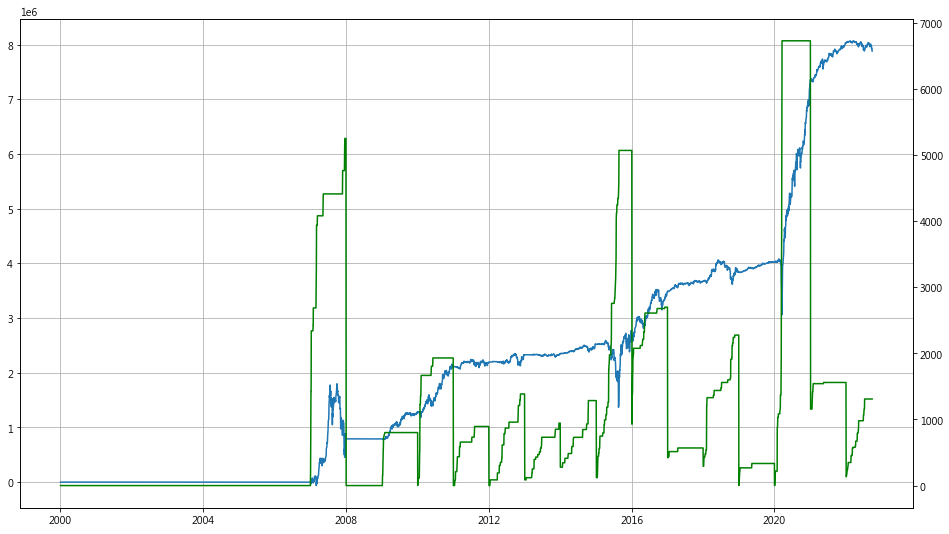

當前持倉:  Index(['3323', '3015', '5469', '2353', '2393', '6270', '3036', '3028', '4935',
       '1604', '6005', '4958'],
      dtype='object')


In [331]:
損益金額(bs_)

<AxesSubplot:xlabel='日期'>

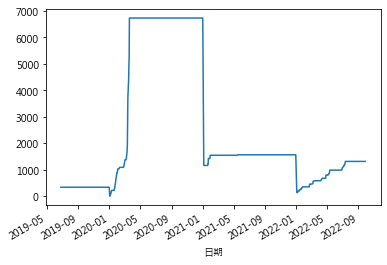

In [329]:
bs.sum(axis=1)[-800:].plot()

In [ ]:
月初轉日 = pd.DataFrame(index=收盤價.index, columns=收盤價.columns)
for i in 月初.index:
    for c in 月初.columns:
        月初轉日.at[i, c] = 月初.at[i, c]

月初轉日.fillna(method='ffill', inplace=True)

In [ ]:
季初轉日 = pd.DataFrame(index=收盤價.index, columns=收盤價.columns)
for i in 季初.index:
    for c in 季初.columns:
        季初轉日.at[i, c] = 季初.at[i, c]

季初轉日.fillna(method='ffill', inplace=True)

In [ ]:
大盤損益 = 大盤收盤價.pct_change().cumsum()
日損益 = (收盤價.pct_change().shift(-1))
月初換股日損益 = 月初轉日 * 日損益
月初換股日平均損益 = 月初換股日損益.sum(axis=1) / 月初轉日.sum(axis=1)
fig, ax = plt.subplots(figsize=(16, 9))
ax1 = ax.twinx()
ax.plot(月初換股日平均損益.fillna(0).cumsum())
ax.plot(大盤損益)
ax1.plot(月初轉日.sum(axis=1), color='green')
ax.grid(True)
plt.show()

In [ ]:
大盤損益 = 大盤收盤價.pct_change().cumsum()
日損益 = (收盤價.pct_change().shift(-1))
季初換股日損益 = 季初轉日 * 日損益
季初換股日平均損益 = 季初換股日損益.sum(axis=1) / 季初轉日.sum(axis=1)
fig, ax = plt.subplots(figsize=(16, 9))
ax1 = ax.twinx()
ax.plot(季初換股日平均損益.fillna(0).cumsum())
ax.plot(大盤損益)
ax1.plot(季初轉日.sum(axis=1), color='green')
ax.grid(True)
plt.show()

In [ ]:
月初轉日.loc['2022-09-01'][月初轉日.loc['2022-09-01']].index

In [ ]:
月初換股損益 = 月初 * 一個月損益.loc[月初.index]
月初換股損益.sum(axis=1).cumsum().plot(figsize=(16, 9))

In [ ]:
月初換股日平均損益 = 月初換股日損益.sum(axis=1) / 月初轉日.sum(axis=1)
月初換股日平均損益.fillna(0).cumsum().plot(figsize=(16, 9))

In [ ]:
月初換股日平均損益.groupby(pd.Grouper(freq='1y')).sum()